In [1]:
#paquetes utilizados
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
import math
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smtsa
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan, het_arch

# Modelos de Suavización Exponencial

Apliquemos a continuación modelos de suavización exponencial a nuestra serie de tiempo, para conocer el comportamiento del pronóstico que se puede alcanzar a partir de estos. En este apartado estaremos aplicando:

1. Suavización Exponencial de Primer Orden (SES)
2. Suavización Exponencial de Segundo Orden (DES)
3. Suavización Exponencial de Tercer Orden (Holt-Winters)

Además, para el caso de la suavización de primer y segundo orden, aplicaremos funciones manuales y otras que hacen uso de la librería de stats-models, para establecer una comparación de desempeño.

Cada una de los apartados a continuación incluyen funciones de creación, selección de mejor modelo y pronóstico.

## 1. Suavización Exponencial de Primer Orden

### 1.1 Suavización exponencial de primer orden sin librería

Para calcular el modelo SES sin librerías se consideran 3 funciones: 
1. _firstsmoothformula_ suaviza la serie de tiempo de interés a a partir de un valor lambda_.
2. _forecastfirstsmooth_ toma la serie de tiempo total, la de training y la que se desea pronosticar, más el factor lambda_ y regresa los valores pronosticados.
3. _firstsmooth_ integra ambas formulas de pronóstico y creación de modelo para probar distintos valores de lambda_ y seleccionar el que menor error MAE retorne.

In [2]:
# SES Sin libreria
#modelo first smooth
def firstsmoothformula(y, lambda_):
    y = pd.Series(y)
    ytilde = y.astype(float)
    start = y.iloc[0]
    ytilde.iloc[0] = lambda_ * y.iloc[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde.iloc[i] = lambda_ * y.iloc[i] + (1 - lambda_) * ytilde.iloc[i - 1]
    return ytilde

#pronosticar con primer orden
def forecastfirstsmooth(ts, actual, forecast, lambda_):
    T = len(actual)
    tau = len(forecast)
    cpi_forecast = np.zeros(tau)
    cpi_smooth1 = np.zeros(T + tau)
    cpi_dates = ts

    for i in range(1, tau + 1):
        cpi_smooth1[:T + i - 1] = firstsmoothformula(y=cpi_dates.iloc[:T + i - 1], lambda_=lambda_)
        cpi_forecast[i - 1] = cpi_smooth1[T + i - 2] + lambda_*(cpi_dates.iloc[T + i - 2] - cpi_smooth1[T + i- 2])
        
    return cpi_forecast

#obtener mejor modelo
def firstsmooth(ts, train, ts_test):
    mae_list = []
    alphas = np.arange(0.1, 0.9, 0.1)
    step = len(ts_test)
    best_mae = float("inf")
    
    for alpha in alphas:
        ses_model = firstsmoothformula(train, alpha)
        y_pred = forecastfirstsmooth(ts, train, ts_test, alpha)
        mae = mean_absolute_error(ts_test, y_pred)
        mae_list.append(mae)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, mae_list

### 1.2 Suavización exponencial de primer orden con stats-models

Por su parte, la opción de creación de SES con la librería de stats models hace uso de 2 funciones: 
1. _firstsmoothstats_: Esta función para distintos valores de lambda_ calcula el modelo SES con uso de stats_models, pronostica el set de validación si es el caso, y selecciona el modelo que haya retornado el menor MAE.
2. _forecastfirstsmoothstats_: Esta función hace uso del modelo SES seleccionado para pronosticar n valores de test o validación.

In [3]:
# SES Con libreria
def firstsmoothstats(train, ts_test):
    mae_list = []
    alphas = np.arange(0.1, 0.9, 0.1)
    step = len(ts_test)
    best_mae = float("inf")
    
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(ts_test, y_pred)
        mae_list.append(mae)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    return best_alpha, ses_model, mae_list

def forecastfirstsmoothstats(ses_model, ts_test):
    step = len(ts_test)
    y_pred = ses_model.forecast(step)
    return y_pred

## 2. Suavización Exponencial de Segundo Orden

### 2.1 Suavización exponencial de segundo orden sin librería

Para calcular el modelo DES sin librerías se consideran 3 funciones: 
1. _secondsmoothformula_ suaviza la serie de tiempo de interés a a partir de un valor lambda_ y la formula de suavización exponencial simple.
2. _forecastsecondsmooth_ toma la serie de tiempo total, la de training y la que se desea pronosticar, más el factor lambda_ y regresa los valores pronosticados.
3. _secondsmooth_ integra ambas formulas de pronóstico y creación de modelo para probar distintos valores de lambda_ y seleccionar el que menor error MAE retorne.

In [4]:
## DES Sin libreria
#obtener el mejor modelo
def secondsmoothformula(train, lambda_):
    trainfs = firstsmoothformula(y=train, lambda_=lambda_)
    trainfs2 = firstsmoothformula(y=trainfs, lambda_=lambda_)
    trainfs2 = 2 * trainfs - trainfs2
    return trainfs2

def secondsmooth(ts, train, ts_test):
    mae_list = []
    alphas = np.arange(0.1, 0.9, 0.1)
    step = len(ts_test)
    best_mae = float("inf")
    
    for alpha in alphas:
        y_pred = forecastsecondsmooth(ts, train, ts_test, alpha)
        mae = mean_absolute_error(ts_test, y_pred)
        mae_list.append(mae)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
            
    return best_alpha, mae_list

#pronosticar con segundo orden
def forecastsecondsmooth(ts, actual, forecast, lambda_):
    T = len(actual)
    tau = len(forecast)
    alpha_lev = 0.05
    cpi_forecast = np.zeros(tau) 
    cl = np.zeros(tau)
    cpi_smooth1 = np.zeros(T + tau)
    cpi_smooth2 = np.zeros(T + tau)
    cpi_dates = ts

    for i in range(1, tau + 1):
        cpi_smooth1[:T + i - 1] = firstsmoothformula(y=cpi_dates.iloc[:T + i - 1], lambda_=lambda_)
        cpi_smooth2[:T + i - 1] = firstsmoothformula(y=cpi_smooth1[:T + i - 1], lambda_=lambda_)
        cpi_forecast[i - 1] = (2 + (lambda_ / (1 - lambda_))) * cpi_smooth1[T + i - 2] - \
                              (1 + (lambda_ / (1 - lambda_))) * cpi_smooth2[T + i - 2]
    return cpi_forecast

### 2.2 Suavización exponencial de segundo orden con stats-models

Por su parte, la opción de creación de DES con la librería de stats models hace uso de 2 funciones: 
1. _secondmoothstats_: Esta función para distintos valores de $alpha$ y $beta$ calcula el modelo DES con uso de stats_models. Recordando que alpha corresponde a la suavización de primer orden y beta al valor de tendencia de la serie. A partir de cada combinación pronostica el set de validación y selecciona la combinación que haya retornado el menor MAE.
3. _forecastsecondsmoothstats_: Esta función hace uso del modelo DES seleccionado para pronosticar n valores de test o validación.

In [5]:
# DES Con libreria

#Obtener mejor modelo
def secondsmoothstats(train, ts_test):
    alphas = np.arange(0.01, 1, 0.10)
    betas  = np.arange(0.01, 1, 0.10)
    best_mae = float("inf")
    step = len(ts_test)
    mae_list = []
    
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend='add').fit(smoothing_level=alpha, smoothing_trend=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(ts_test, y_pred)
            mae_list.append(mae)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    return best_alpha, best_beta, des_model, mae_list

#pronosticar
def forecastsecondsmoothstats(des_model, ts_test):
    step = len(ts_test)
    y_pred = des_model.forecast(step)
    return y_pred

## 3. Suavización Exponencial de Tercer Orden (Holt-Winters)

Por su parte, la opción de creación de DES con la librería de stats models hace uso de 2 funciones: 
1. _tes_optimizer_: Esta función para distintos valores de $alpha$, $beta$, $gamma$ calcula el modelo de Holt Winters con uso de stats_models. Recordando que alpha corresponde a la suavización de primer orden, beta al valor de tendencia de la serie y gamma a la estacionalidad. A partir de cada combinación pronostica el set de validación y selecciona la combinación que haya retornado el menor MAE.
3. _forecaststhirdsmooth_: Esta función hace uso del modelo de Holt-Winters seleccionado para pronosticar n valores de test o validación.

In [6]:
#Holt winters
#Obtener mejor modelo
def tes_optimizer(train, ts_test):
    alphas = betas = gammas = np.arange(0.1, 0.8, 0.1)
    abg = list(itertools.product(alphas, betas, gammas))
    best_seasonal_periods, best_alpha, best_beta, best_gamma, best_mae = None, None, None, None, float("inf")
    step = len(ts_test)
    mae_list = []
    
    for comb in abg:
        for seasonal_periods in range(2,7):
            tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).\
                fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
            y_pred = tes_model.forecast(len(val))
            mae = mean_absolute_error(ts_test, y_pred)
            mae_list.append(mae)
            if mae < best_mae:
                best_alpha, best_beta, best_gamma, best_mae, best_seasonal_periods = comb[0], comb[1], comb[2], mae, seasonal_periods
                
    return best_alpha, best_beta, best_gamma, best_seasonal_periods, mae_list, 

#pronosticar
def forecaststhirdsmooth(hw_model, ts_test):
    step = len(ts_test)
    y_pred = hw_model.forecast(step)
    return y_pred

## 4. Funciones complementarias

1. La función _split_ recibe como parámetros la serie de tiempo de entrenamiento y la porción deseada de datos para conjunto de test y validación. Internamente las separa y devuelve los conjuntos para ser utilizados en la preparación y pronóstico del modelo.

In [7]:
def split(serie, trainportion):
    perct = math.ceil(len(ts) * trainportion)
    perc2 = math.ceil(len(ts)*((1 - trainportion)/2))
    train = serie[0:perct]
    validation = serie[perct:perct+perc2]
    test = serie[perct+perc2:]
    return train, validation, test

2. La función _errors_ recibe el set pronosticado y el set con los valores originales y retorna todas las métricas de error requeridas, MAE, MAPE, RMSE y R2.

In [8]:
#calculo de los errores
def errors(y_pred, y_real):
    
    mae = mean_absolute_error(y_real, y_pred)
    mape = 100*(sum(abs(((y_real - y_pred)/y_real)))/len(y_real))
    mse = mean_squared_error(y_real , y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    
    return mae, mape, mse, rmse, r2

3. La función de _assumptions_ testea para los residuos del modelo su desempeño en la prueba de independencia de ljung_box, la de normalidad de jarque-bera y heterocedasticidad. Retorna los p valores para cada una y si se requiere además lanza un warning explicando qué supuesto no se cumplió en los residuos.

In [9]:
#evaluacion de supuestos
def assumptions(residuals):

    warning = ""
    a = 0
    
    #Independency
    #H0: The residuals are independent.
    #H1: The residuals aren't independent.    
    ljung_box_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    ljung_box_pvalue = ljung_box_test['lb_pvalue'].values[0]
    if ljung_box_pvalue < 0.05:
        warning= warning + " The residuals aren't independent"
        a=a+1

    #Normality test
    #H0: The residuals have a normal distribution.
    #H1: The residuals don't have a normal distribution.
    jb_stat, jb_pvalue, skewness, kurtosis = jarque_bera(residuals)
    if jb_pvalue < 0.05:
        a = a+1
        warning = warning + " The residuals do not follow a normal distribution"

    #homocedasticity
    #H0: The residuals are homocedastic.
    #H1: The residuals aren't homocedastic.
    arch_stat, arch_pvalue, _, _ = het_arch(residuals)
    if arch_pvalue < 0.05:
        warning= warning + " The residuals aren't homocedastic"
        a=a+1

    return arch_pvalue, jb_pvalue, ljung_box_pvalue, warning

## 5. Aplicación de modelos de suavización

En este apartado aplicaremos los 5 modelos descritos anteriormente y generaremos una base de datos que captará los resultados para cada uno, en cuanto al entrenamiento y el pronóstico del conjunto de test. Carguemos la base de datos:

In [10]:
df=pd.read_excel("loadsts.xlsx")
df.index = df['Posted_date']
ts = df['Loads']
val_result = []
test_result = []

Para la modelación haremos uso en todo momento de un 70% de los datos para el conjunto de entrenamiento y el restante 30% se divide a la mitad para validación y testing.

In [11]:
train, val, test = split(ts, 0.7)

### 5.1 Suavización Exponencial de Primer Orden

### 5.1.1. Implementación SES Sin librería

Iniciemos con la suavización de primer orden sin librería de stats-model.

In [12]:
#Suavización de primer orden sin librería

#Preparación del modelo
lambda_, mae_list = firstsmooth(ts, train, val) #selección del mejor modelo
ybarra = firstsmoothformula(train, lambda_)
residuals_m = train - ybarra #obtención de residuales del modelo
val_pred = forecastfirstsmooth(ts, train, val, lambda_) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

KeyboardInterrupt: 

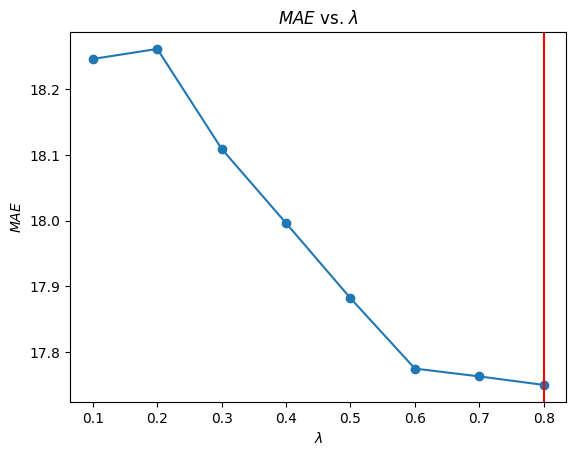

In [53]:
plt.plot(np.arange(0.1, 0.9, 0.1), mae_list, marker='o', linestyle='-')
plt.title("$MAE$ vs. $\lambda$")
plt.xlabel('$\lambda$')
plt.ylabel('$MAE$')
plt.axvline(x=lambda_, color='red')
plt.show()

Al evaluar este modelo de suavización podemos hacer un análisis comparativo del valor del Mean Absolute Error (MAE) a distintos valores de lambda. El menor en la evaluación se alcanzó con un valor de 0,8. Utilicemos este valor para pronosticar el testing.

In [56]:
#Suavización de primer orden sin librería

#Pronóstico de testing
tt = pd.concat([train,val]) #unir validación con training
test_pred = forecastfirstsmooth(ts, tt, test, lambda_) #pronosticar el testing
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

#guardar los resultados
val_result.append(["first_smooth_nolibrary", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["first_smooth_nolibrary", mape_t, mae_t, mse_t, rmse_t, r2_t])

### 5.1.2. Implementación SES con stats-model

Ahora apliquemos suavización exponencial de primer orden haciendo uso de la librería de stats-models.

In [66]:
#Suavización de primer orden stats-model

#Preparación del modelo
alpha, ses_model, mae_list = firstsmoothstats(train, val) #selección del mejor modelo
residuals_m = ses_model.resid #obtención de residuales del modelo
val_pred = forecastfirstsmoothstats(ses_model, val) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

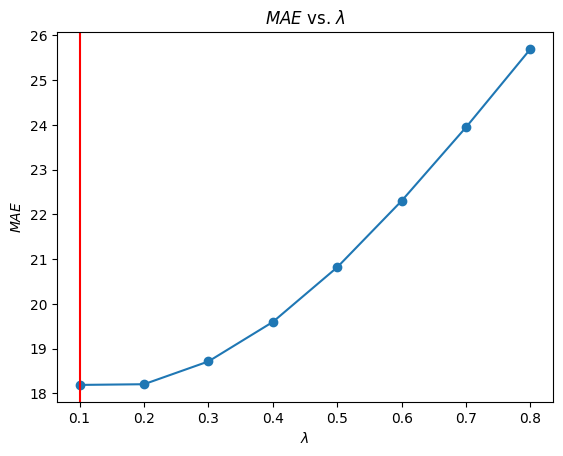

In [68]:
plt.plot(np.arange(0.1, 0.9, 0.1), mae_list, marker='o', linestyle='-')
plt.title("$MAE$ vs. $\lambda$")
plt.xlabel('$\lambda$')
plt.ylabel('$MAE$')
plt.axvline(x=alpha, color='red')
plt.show()

El comportamiento de la gráfica de creación de modelo cuando se realiza a partir de la librería de stats-models es completamente distinta, en este caso el mejor valor del MAE se consigue cuando lambda es igual a 0,1. Además se observa que el MAE para el mejor caso es **mayor que la función de creación del modelo manual**.

In [69]:
#Pronóstico de testing
ses_model = SimpleExpSmoothing(tt).fit(smoothing_level=alpha, optimized=False)
test_pred = forecastfirstsmoothstats(ses_model, test)
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

#guardar los resultados
val_result.append(["first_smooth_stats", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["first_smooth_stats", mape_t, mae_t, mse_t, rmse_t, r2_t])

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### 5.2 Suavización Exponencial de Segundo Orden

A continuación iniciemos con los modelos de suavización de segundo orden, que consideran el factor de tendencia de la serie.

### 5.2.1. Implementación DES Sin librería

In [81]:
#Suavización de segundo orden sin librería

#Preparación del modelo
lambda_, mae_list = secondsmooth(ts, train, val) #selección del mejor modelo
ybarra = secondsmoothformula(train, lambda_)
residuals_m = train - ybarra
val_pred = forecastsecondsmooth(ts, train, val, lambda_) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8


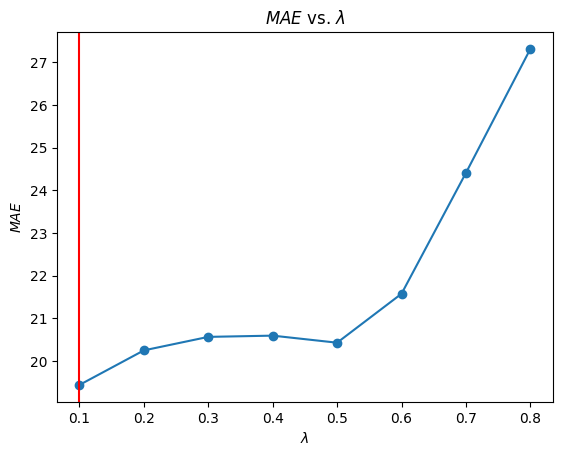

In [84]:
plt.plot(np.arange(0.1, 0.9, 0.1), mae_list, marker='o', linestyle='-')
plt.title("$MAE$ vs. $\lambda$")
plt.xlabel('$\lambda$')
plt.ylabel('$MAE$')
plt.axvline(x=alpha, color='red')
plt.show()

Para este caso, el modelo de suavización exponencial doble considera el valor de lambda 0.1, como el que genera menor MAE en los resultados, sin embargo, es importante observar que a pesar de que considera el factor de tendencia existente en la serie de tiempo, no presenta un MAE menor a los obtenidos con la suavización de primer orden. Al menos en el conjunto de entrenamiento. Utilicemos este modelo para pronosticar.

In [85]:
#Suavización de segundo orden sin librería

#Pronóstico de testing
test_pred = forecastsecondsmooth(ts, tt, test, lambda_) #pronosticar el testing
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

#guardar los resultados
val_result.append(["second_smooth_nolibrary", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["second_smooth_nolibrary", mape_t, mae_t, mse_t, rmse_t, r2_t])

### 5.2.2. Implementación DES stats-model

In [86]:
#Suavización de segundo orden stats-model

#Preparación del modelo
alpha, beta, des_model, mae_list = secondsmoothstats(train, val) #selección del mejor modelo
residuals_m = des_model.resid #obtención de residuales del modelo
val_pred = forecastsecondsmoothstats(des_model, val) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was 

Observemos a continuación el comportamiento del MAE con respecto a las múltiples combinaciones que pueden tomar los parámetros de alpha y beta durante la creación del modelo.

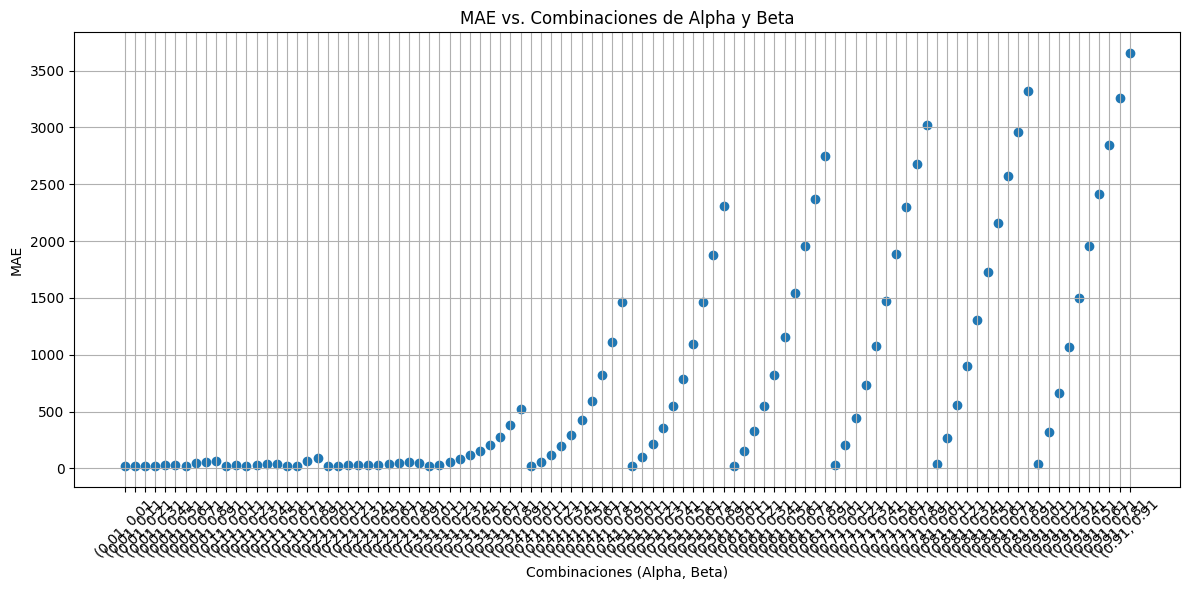

In [89]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
alpha_beta_combinations = []

for alpha in alphas:
    for beta in betas:
        alpha_beta_combinations.append(f"({alpha:.2f}, {beta:.2f}")

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.scatter(alpha_beta_combinations, mae_list, marker='o')
plt.title('MAE vs. Combinaciones de Alpha y Beta')
plt.xlabel('Combinaciones (Alpha, Beta)')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

A partir de este gráfico podemos analizar que cuando se mantienen valores pequeños de alpha y beta se alcanza un mejor desempeño en el modelo. Pronostiquemos entonces el testing con la mejor combinación de parámetros.

In [90]:
#Pronóstico de testing
des_model = ExponentialSmoothing(tt, trend='add').fit(smoothing_level=alpha, smoothing_trend=beta)
test_pred = forecastsecondsmoothstats(des_model, test)
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

#guardar los resultados
val_result.append(["second_smooth_stats", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["second_smooth_stats", mape_t, mae_t, mse_t, rmse_t, r2_t])

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## 5.3 Implementación Holt Winters

Por último implementaremos el modelo de Holt-Winters que considera además de la tendencia, la estacionalidad existente en la serie de tiempo.

In [177]:
#Holt winters stats-model

#Preparación del modelo
alpha, beta, gamma, seasonal_periods, mae_list = tes_optimizer(train, val) #selección del mejor modelo
tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).\
                fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
residuals_m = tes_model.resid #obtención de residuales del modelo
val_pred = forecaststhirdsmooth(tes_model, val) #pronosticar validación
mae_v, mape_v, mse_v, rmse_v, r2_v = errors(val_pred, val) #scores validación
arch_pvalue, jb_pvalue, ljung_box_pvalue, warning = assumptions(residuals_m) #análisis de los residuales

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\AppData\Local\Temp\ipykernel_1396\933076862.py:12: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).\
C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\AppData\Local\Temp\ipykernel_1396\933076862.py:12: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  tes_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods).\
C:\Users\kgome\anaconda3\envs\myenv\li

In [190]:
ss = pd.DataFrame({'comb':list(itertools.product(alphas, betas, gammas,s)),'mae':pd.Series(mae_list)})
ss = ss.sort_values('mae',ascending=True)
ss.head(10)

,comb,mae
152,"(0.1, 0.5, 0.30000000000000004, 4)",16.432706
75,"(0.1, 0.30000000000000004, 0.2, 2)",16.492292
181,"(0.1, 0.6, 0.2, 3)",16.619932
77,"(0.1, 0.30000000000000004, 0.2, 4)",16.629037
117,"(0.1, 0.4, 0.30000000000000004, 4)",16.636291
182,"(0.1, 0.6, 0.2, 4)",16.651881
271,"(0.2, 0.1, 0.6, 3)",16.668131
245,"(0.2, 0.1, 0.1, 2)",16.670168
257,"(0.2, 0.1, 0.30000000000000004, 4)",16.684892
171,"(0.1, 0.5, 0.7000000000000001, 3)",16.717870


Para este entrenamiento el mejor valor de MAE se obstuvo con la combinación alpha = 0.1, beta = 0.5, gamma = 0.3 y además con 4 períodos de estacionalidad considerados.

In [191]:
#Pronóstico de testing
tes_model = ExponentialSmoothing(tt, trend='add', seasonal='add', seasonal_periods=seasonal_periods).\
                fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
test_pred = forecaststhirdsmooth(tes_model, test)
mae_t, mape_t, mse_t, rmse_t, r2_t = errors(test_pred, test) #scores testing

#guardar los resultados
val_result.append(["third_smooth_stats", mape_v, mae_v, mse_v, rmse_v, r2_v, arch_pvalue, jb_pvalue, ljung_box_pvalue, warning])
test_result.append(["third_smooth_stats", mape_t, mae_t, mse_t, rmse_t, r2_t])

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\kgome\AppData\Local\Temp\ipykernel_1396\67590285.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  tes_model = ExponentialSmoothing(tt, trend='add', seasonal='add', seasonal_periods=seasonal_periods).\


In [192]:
dfval = pd.DataFrame(val_result, columns=['model', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'arch_pvalue', 'jb_pvalue', 'ljung_box_pvalue', 'warning'])
dftest = pd.DataFrame(test_result, columns=['model', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])  

In [196]:
dftest.to_excel("results/smoothingtest.xlsx")
dfval.to_excel("results/smoothingval.xlsx")

## 6. Resultados

Una vez que hemos ejecutado todos los modelos de suavización exponencial, es momento de analizar los resultados y seleccionar el modelo con el mejor desempeño. Este modelo podría haber logrado el mejor rendimiento en todos los casos, o tal vez se destacó únicamente en ciertos aspectos. Es importante investigar los parámetros con los que se construyó y comparar su comportamiento tanto durante la fase de entrenamiento como en el pronóstico aplicado al conjunto de prueba.

Además es posible por motivos de cumplimiento de supuestos algún modelo no sea apropiado para pronosticar, por lo que podría resultar más apropiado hacer uso de otro, entre otras cosas. Analicemos inicialmente en la validación.

### 6.1 Resultados en el entrenamiento de los modelos

In [200]:
dfval

,model,MAPE,MAE,MSE,RMSE,R2,arch_pvalue,jb_pvalue,ljung_box_pvalue,warning
0,first_smooth_nolibrary,inf,17.749677,6.405293e+02,25.308680,-0.534496,3.508682e-95,4.598160e-07,3.897686e-01,The residuals do not follow a normal distribu...
1,first_smooth_stats,inf,25.698118,8.108554e+02,28.475524,-0.942541,3.508682e-95,4.598160e-07,3.897686e-01,The residuals do not follow a normal distribu...
2,second_smooth_nolibrary,inf,19.434899,4.989891e+02,22.338064,-0.195413,2.382316e-62,2.789931e-09,2.203987e-10,The residuals aren't independent The residual...
3,second_smooth_stats,inf,3654.465418,1.769809e+07,4206.910005,-42397.769050,2.605093e-60,7.543038e-01,7.244781e-15,The residuals aren't independent The residual...
4,third_smooth_stats,inf,16.432706,4.572724e+02,21.383928,-0.095473,1.396011e-57,9.771168e-12,2.223971e-17,The residuals aren't independent The residual...


**Key insights**

1. A simple vista podemos observar que el modelo de segundo orden creado con la librería de stats-model fue el que presentó el peor desempeño. Para todos los errores calculados, además no cumplió los supuestos de independencia.
2. Tanto el modelo de suavización de primer y segundo orden creados con las funciones de Python tuvieron mejor desempeño que los creados con las librerías de stats-models.
3. En los dos modelos de primer orden, le fue mejor que en la suavización de segundo orden que considera el factor de tendencia. Entre ambas, la función de primer orden obtuvo mejor que la librería de stats-models para cálculo de suavización simple.
4. El mejor MAE en el conjunto de validación fue sin duda el calculado con el modelo de Holt-Winters, que tuvo en cuenta la estacionalidad presente en la serie, sin embargo este mejor modelo no cumple los supuestos de independencia, normalidad ni heterocedasticidad, lo que puede causar problemas posteriores en el cálculo de los pronósticos.
5. En general ninguno de estos modelos se ajusta bien a los datos de validación. Todos los R2 son menores a cero, lo que significa que no tienen la capacidad de explicar la variabilidad de los datos de manera adecuada.
6. Solo los modelos de suavización de primer orden cumplieron el supuesto de independencia.
7. La mayoría utilizó valores de suavización de pequeño tamaño entre 0.1 y 0.5.

### 6.2 Resultados en el testing de los modelos

Ahora analicemos los resultados para el conjunto de test:

In [209]:
dftest

,model,MAPE,MAE,MSE,RMSE,R2
0,first_smooth_nolibrary,inf,18.550234,646.358622,25.423584,-0.650460
1,first_smooth_stats,inf,17.655871,394.748509,19.868279,-0.007980
2,second_smooth_nolibrary,inf,18.625471,470.840858,21.698868,-0.202280
3,second_smooth_stats,inf,39.774061,2214.369236,47.057085,-4.654335
4,third_smooth_stats,inf,91.402962,11399.635792,106.769077,-28.108679


**Key insights**

1. A pesar de que el modelo de Holt-Winters fue el mejor modelo durante el entrenamiento, la falta de cumplimiento de supuestos afectó su capacidad de pronóstico y presentó el error más alto en todos los modelos presentados.
2. En estos resultados se observa la relevancia del supuesto de independencia de los errores, dado que los 2 modelos que cumplieron estos supuestos fueron justo los 2 que mejor MAE presentaron y corresponde a los dos modelos de suavización de primer orden. 
3. Aunque en la validación la librería de stats-model para primer orden presentó el cuarto mejor MAE, durante el conjunto de testing presentó el mejor valor con 17.6 cargas de error.
4. El R2 para todos los modelos se mantuvo en negativo, es decir, que mantienen una capacidad baja para capturar los patrones de variabilidad de la serie de tiempo.

## 6.3 Selección de mejor modelo

En conclusión al hacer el análisis de estos modelos de suavización exponencial de primer, segundo y tercer orden, observamos que el modelo que mejor desempeño tuvo durante el conjunto de test fue el modelo de primer orden generado con la librería de stats-models. Además analizamos que el supuesto de independencia influye de alta manera en la capacidad del pronóstico del modelo y que estos modelos presentan R2 muy bajos, dada su baja capacidad para captar patrones de alta variabilidad en la serie de tiempo de estudio.

**En otro estudio se pueden mejorar los ciclos para que selecciones solo los valores de lambda donde el supuesto de independencia se cumpla.**

Construyamos de nuevo el modelo de suavización de primer orden con el valor de lambda_ que presentó el mejor MAE y grafiquemos el comportamiento de la predicción.

In [210]:
ses_model = SimpleExpSmoothing(tt).fit(smoothing_level=0.1, optimized=False)
test_pred = forecastfirstsmoothstats(ses_model, test)

C:\Users\kgome\anaconda3\envs\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


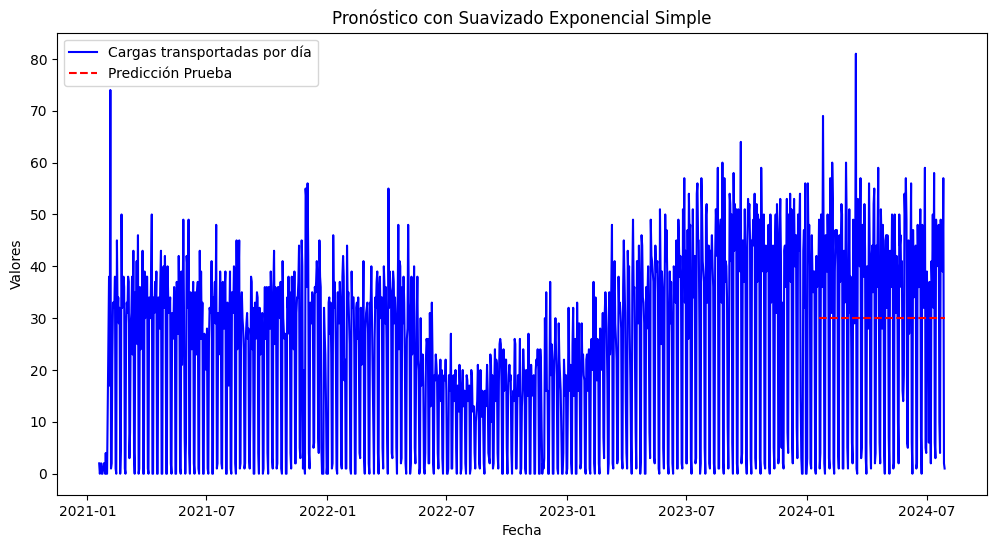

In [211]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Cargas transportadas por día', color='blue')
plt.plot(test.index, test_pred, label='Predicción Prueba', color='red', linestyle='--')
plt.title('Pronóstico con Suavizado Exponencial Simple')
plt.xlabel('Fecha')
plt.ylabel('Cargas transportadas')
plt.legend()
plt.show()

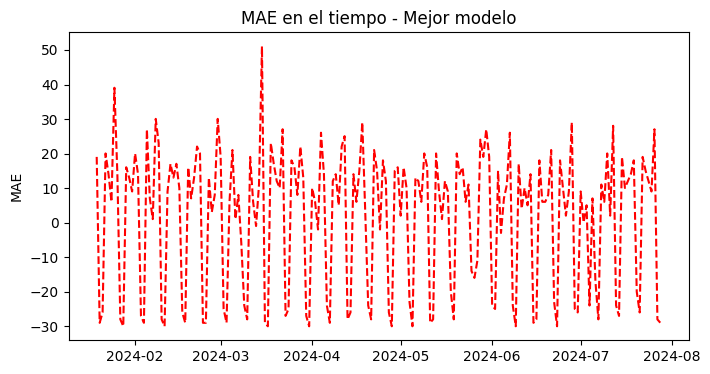

In [216]:
plt.figure(figsize=(8, 4))
plt.plot(test.index, test-test_pred, label='Predicción Prueba', color='red', linestyle='--')
plt.ylabel('MAE')
plt.title('MAE en el tiempo - Mejor modelo')
plt.show()

La predicción constante de la suavización exponencial de primer orden claramente no podrá captar la variación natural de la demanda de cargas diarias y estos patrones no estacionarios.